In [11]:
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import tqdm

myseed = 12345
torch.manual_seed(myseed)
torch.random.manual_seed(myseed)
random.seed(0)
np.random.seed(myseed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(myseed)
torch.autograd.set_detect_anomaly(True)  # 可在NaN 出现时报错，定位错误代码。正向传播时：开启自动求导的异常侦测
# 反向传播时：在求导时开启侦测
#with torch.autograd.detect_anomaly():
#    loss.backward()
torch.multiprocessing.set_sharing_strategy('file_system')

In [12]:
# 使用 GPU
def try_gpu(i=0):  #@save
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')
def try_all_gpus():  #@save
    """返回所有可用的GPU，如果没有GPU，则返回[cpu(),]"""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

In [13]:
# 数据预处理, 调整图片大小
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize([96, 96])])

# 下载Fashion-MNIST训练集数据，并构建训练集数据载入器trainloader,每次从训练集中载入64张图片，每次载入都打乱顺序
trainset = torchvision.datasets.FashionMNIST('../dataset/', download=False, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# 下载Fashion-MNIST测试集数据，并构建测试集数据载入器trainloader,每次从测试集中载入64张图片，每次载入都打乱顺序
testset = torchvision.datasets.FashionMNIST('../dataset/', download=False, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [14]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

In [15]:
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

array([<Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 'dress'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'coat'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'shirt'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'bag'}>, <Axes: title={'center': 'coat'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 'coat'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'coat'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'dress'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 'sandal'}>,
       <A

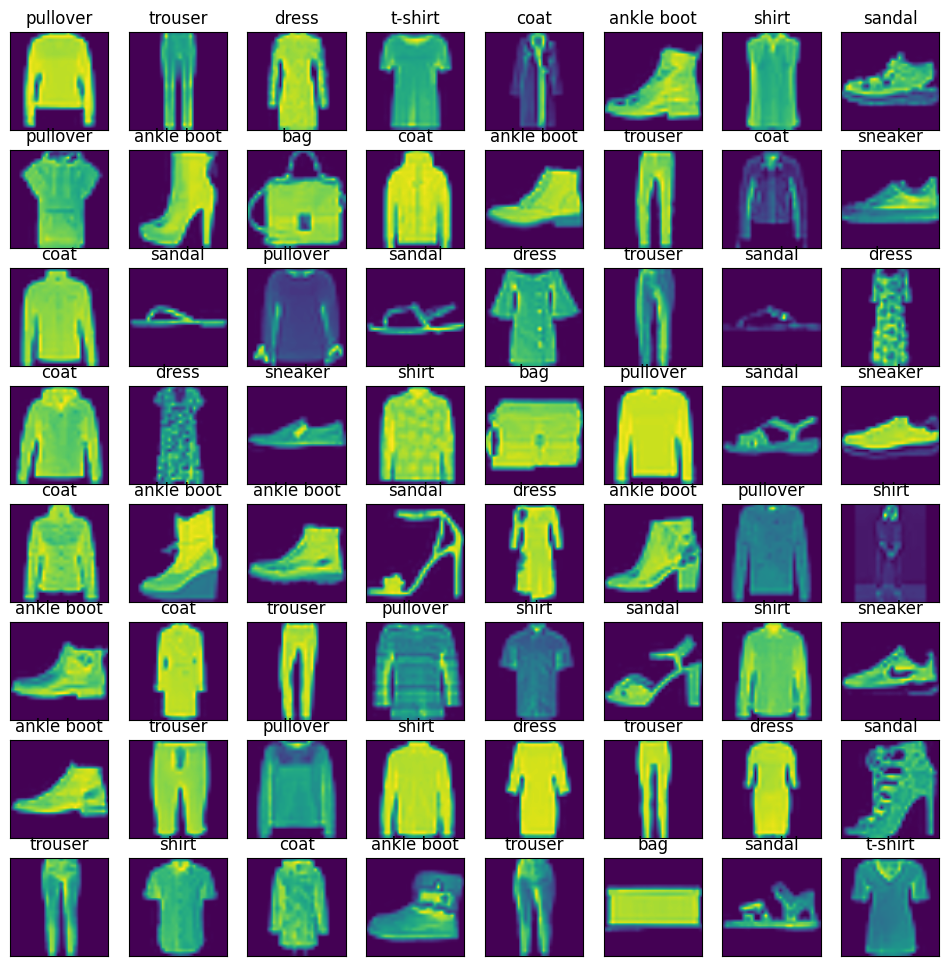

In [16]:
x, y = next(iter(trainloader))
show_images(x.reshape(64, 96, 96), 8, 8, titles=get_fashion_mnist_labels(y))

In [17]:
class Net(torch.nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=1),
            torch.nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Flatten(),
            torch.nn.Linear(4096, 4096),
            torch.nn.Linear(4096, 1000),
            torch.nn.Linear(1000, 10),
        )

    def forward(self, x):
        return self.net(x)

In [18]:
model = Net()
model = model.to(device=try_gpu())

# 定义优化器和损失函数
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1) # 更新学习率

model.train()
epochs= 5

Loss_data = {
    "train": [],
    "dev": []
}

acc_data = {
    "train": [],
    "dev": []
}

# 训练
for epoch in range(epochs):
    Loss = 0
    with tqdm.tqdm(total=trainloader.__len__()) as pbar:
        model.train()
        running_train_loss = 0.0
        for batch_x, batch_y in trainloader:
            x, y = batch_x.to(device=try_gpu()), batch_y.to(device=try_gpu())
            prediction = model(x)
            loss = criterion(prediction, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            pbar.update(1)
            running_train_loss += loss.item()
        
        scheduler.step()
        
        # 训练损失
        epoch_train_loss = running_train_loss / len(trainloader)
        model.eval()
        Loss_data["train"].append(epoch_train_loss)

        # 测试损失
        model.eval()
        running_test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in testloader:
                x, y = inputs.to(device=try_gpu()), targets.to(device=try_gpu())
                outputs = model(x)
                loss = criterion(outputs, y)
                running_test_loss += loss.item()
        epoch_test_loss = running_test_loss / len(testloader)
        Loss_data["dev"].append(epoch_test_loss)

        i = 0
        accuracy_sum = 0
        for images, labels in testloader:
            images = images.to(device=try_gpu())
            labels = labels.to(device=try_gpu())
            y_predict = model(images)
            y_predict = torch.argmax(y_predict, dim = 1)
            accuracy = torch.eq(labels, y_predict).float().mean()
            accuracy_sum = accuracy_sum + accuracy.item()
            i = i + 1
        acc_data["dev"].append(accuracy_sum / i)

        i = 0
        accuracy_sum = 0
        for images, labels in trainloader:
            images = images.to(device=try_gpu())
            labels = labels.to(device=try_gpu())
            y_predict = model(images)
            y_predict = torch.argmax(y_predict, dim = 1)
            accuracy = torch.eq(labels, y_predict).float().mean()
            accuracy_sum = accuracy_sum + accuracy.item()
            i = i + 1
        acc_data["train"].append(accuracy_sum / i)

100%|██████████| 938/938 [02:15<00:00,  6.95it/s]


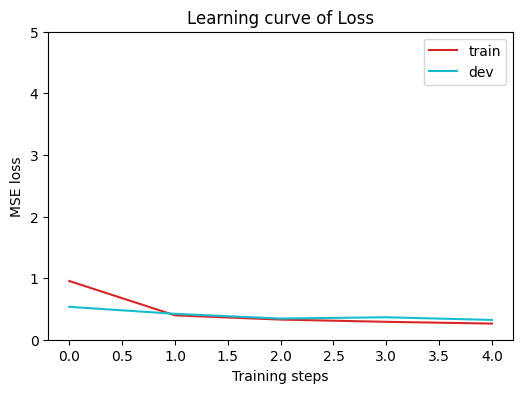

In [21]:
def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    x_1 = [i for i in range(len(loss_record['train']))]
    x_2 = [i for i in range(len(Loss_data["dev"]))]
    plt.figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

plot_learning_curve(Loss_data, "Loss")

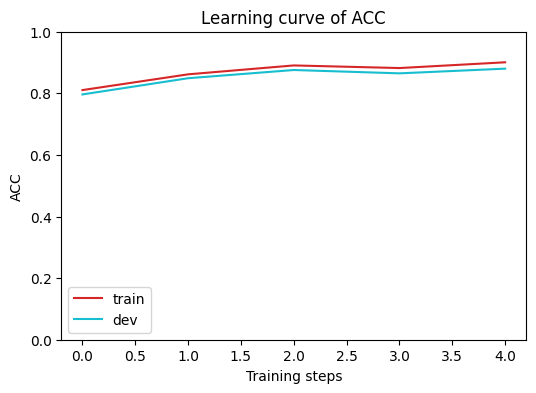

In [24]:
def plot_acc_curve(acc_record, title=''):
    x_1 = [i for i in range(len(acc_record['train']))]
    x_2 = [i for i in range(len(acc_record["dev"]))]
    plt.figure(figsize=(6, 4))
    plt.plot(x_1, acc_record['train'] , c='tab:red', label='train')
    plt.plot(x_2, acc_record['dev'] , c='tab:cyan', label='dev')
    plt.ylim(0.0, 1.)
    plt.xlabel('Training steps')
    plt.ylabel('ACC')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

plot_acc_curve(acc_data, "ACC")